In [5]:
using PyCall
using Distances
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf

In [10]:
py"""
import numpy as np
import cv2
print(cv2.__version__)


class RootSIFT:
    def __init__(self):
        self.extractor = cv2.xfeatures2d.SIFT_create()

    def compute(self, image, kps, eps=1e-7):
        (kps, descs) = self.extractor.compute(image, kps)
        if len(kps) == 0:
            return ([], None)

        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        return (kps, descs)
def rootSIFT(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    (kps, descs) = sift.detectAndCompute(gray, None)
    rs = RootSIFT()
    (kps, descs) = rs.compute(gray, kps)
    pos = [np.array([x.pt[0], x.pt[1]]) for x in kps]
    return np.array(pos)

"""

img1_path = "../data/test/test_1.jpg"
img2_path = "../data/test/test_2.jpg"

descs1 = py"rootSIFT"(img1_path);
descs2 = py"rootSIFT"(img2_path);

In [35]:
cost = pairwise(Euclidean(), descs1', descs2'; dims=2);

36×37 Array{Float64,2}:
  9.48607  38.7713    5.22998   5.22998  …  41.8245   45.4852   50.1555 
 40.6125    9.04781  51.5333   51.5333      66.8945   63.9992   56.6489 
 25.3195    8.10832  35.3447   35.3447      53.752    52.2654   47.8374 
 21.1292   15.9307   28.7514   28.7514      46.2554   45.2516   42.1301 
 51.9298   20.5743   62.0642   62.0642      73.0267   69.0      59.6457 
 51.9298   20.5743   62.0642   62.0642   …  73.0267   69.0      59.6457 
 39.6988   10.4407   49.0275   49.0275      61.0352   57.7259   49.8935 
 20.5907   45.8926    6.68478   6.68478     31.5311   36.3148   43.4056 
 47.7721   16.8839   57.5113   57.5113      68.3569   64.4778   55.4741 
 53.8739   22.8413   63.5185   63.5185      72.8402   68.5013   58.6565 
 53.8739   22.8413   63.5185   63.5185   …  72.8402   68.5013   58.6565 
 33.9274   11.4067   41.839    41.839       53.1096   50.141    43.246  
 26.2199   17.9129   31.7264   31.7264      43.5534   41.6136   37.1505 
  ⋮                        

In [38]:
P = ones(size(descs1,1));
Q = ones(size(descs2,1));

In [52]:
solCount = 1000
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0,PoolGap = 0.01))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P), sum(Q)))
@constraint(m, X * ones(Int, length(Q)) .<= P)
@constraint(m, X'ones(Int, length(P)) .<= Q);
optimize!(m)
solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 74 rows, 1332 columns and 3996 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve time: 0.00s
Presolved: 74 rows, 1332 columns, 3996 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3730852e+01   7.000000e+01   0.000000e+00      0s
      99    3.5632099e+02   0.000000e+00   0.000000e+00      0s

Solved in 99 iterations and 0.01 seconds
Optimal objective  3.563209914e+02


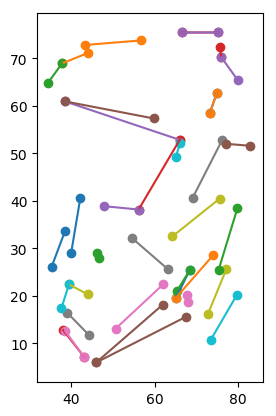

In [54]:
# solOther = sparse(sol_pool[1,:,:])
solOther = sparse(value.(X))
for (x,y,v) in zip(findnz(solOther)...)
    
    x_pos = [descs1'[:,x][1], descs2'[:,y][1]]
    y_pos = [descs1'[:,x][2], descs2'[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
end